In [1]:
#previously been using Gaussian Kernel (with sample_region_width set to 1 and width set to 1e4)
#starting to think that Hann window would be better
#compare the first arlongterm with the different methods

In [2]:
import sys, os
from astropy.io import fits
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from datetime import datetime as dt
import time
import _pickle as cPickle
import astropy.units as u
import imreg_dft
import numpy as np

from sunpy.coordinates import get_body_heliographic_stonyhurst, frames
from astropy.wcs import WCS
import reproject
from reproject import reproject_adaptive,reproject_exact,reproject_interp
from scipy.ndimage import map_coordinates

from apply_hmi_psf import *

import sunpy.visualization.colormaps
font = {'family' : 'Open Sans',
        'weight' : 'normal',
        'size'   : 15}

import sunpy.visualization.colormaps as cm
import matplotlib as mpl
magmap = mpl.colormaps['hmimag']

import matplotlib.patches as patches
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/scratch/slam/sinjan/.conda/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(reproject.__version__)

0.14.0


In [12]:
def get_hrt_remapped_R(hrt_file, hmi_file, err, kernel, apply_hmi_psf=False):
    
    from datetime import datetime as dt
    print(dt.now())

    errx=err[0]
    erry=err[1]
    h = fits.getheader(hrt_file)
    h['CRVAL1']=h['CRVAL1']-errx
    h['CRVAL2']=h['CRVAL2']-erry
    tmp = fits.getdata(hrt_file)

    if apply_hmi_psf:
        phi_dsun = h['DSUN_OBS']
        hmi_psf = make_psf_hmi_th(tmp.shape[0],phi_dsun)
        hmi_psf /= hmi_psf.max()
        tmp = fftshift(ifft2(fft2(tmp)/tmp.size * fft2(hmi_psf/hmi_psf.sum())).real * tmp.size) 
    
    #arr=np.zeros(tmp.shape)
    #arr[150:-150,150:-150]=tmp[150:-150,150:-150]
    hrt_map = sunpy.map.Map(tmp,h)

    #magnetogram = sunpy.map.Map(hmi_file).rotate()
    #hpc_coords = sunpy.map.all_coordinates_from_map(magnetogram)
    #mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
    #hmi_map = sunpy.map.Map(magnetogram.data, magnetogram.meta, mask=mask)
    hmi_map=sunpy.map.Map(hmi_file).rotate()

    out_header = sunpy.map.make_fitswcs_header(
         hmi_map.data.shape, hmi_map.reference_coordinate.replicate(rsun=hrt_map.reference_coordinate.rsun),
         scale=u.Quantity(hmi_map.scale),
         instrument="SO/PHI-HRT",
         observatory="SolO",
         wavelength=hrt_map.wavelength
         )
    out_header['dsun_obs'] = hmi_map.coordinate_frame.observer.radius.to(u.m).value
    out_header['hglt_obs'] = hmi_map.coordinate_frame.observer.lat.value
    out_header['hgln_obs'] = hmi_map.coordinate_frame.observer.lon.value
    
    out_header['crpix1'] = hmi_map.fits_header['CRPIX1']
    out_header['crpix2'] = hmi_map.fits_header['CRPIX2']
    out_header['crval1'] = hmi_map.fits_header['CRVAL1']
    out_header['crval2'] = hmi_map.fits_header['CRVAL2']    
    out_header['PC1_1'] = hmi_map.fits_header['PC1_1']
    out_header['PC1_2'] = hmi_map.fits_header['PC1_2']
    out_header['PC2_1'] = hmi_map.fits_header['PC2_1']
    out_header['PC2_2'] = hmi_map.fits_header['PC2_2']
    out_header['cdelt1'] = hmi_map.fits_header['cdelt1']
    out_header['cdelt2'] = hmi_map.fits_header['cdelt2']
    out_WCS=WCS(out_header)

    hrt_repro, footprint = reproject_adaptive(hrt_map, out_WCS, hmi_map.data.shape,kernel=kernel,sample_region_width=1,kernel_width=10000)
    hrt_repro=sunpy.map.Map((hrt_repro, out_WCS))
    
    return hrt_repro, hmi_map

In [5]:
filedir = '/data/solo/phi/data/fmdb/public/l2/2023-10-12/'
bfile = 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz'
hrt_file = filedir+bfile

hmifiledir = '/scratch/slam/sinjan/arlongterm_hmi/'
hmibfile = 'blos_45/hmi.m_45s.20231012_002145_TAI.2.magnetogram.fits'
hmi_file = hmifiledir+hmibfile

In [6]:
hrt_121023_b = fits.getdata(filedir+bfile)
hrt_121023_bm = sunpy.map.Map(filedir+bfile)
hmi_121023_b = sunpy.map.Map(hmifiledir+hmibfile).rotate()

In [7]:
def get_hmi_hrt_aligned(hrt_file,hmi_file,kernel,apply_hmi_psf):
    err=(-1.934214925750382, 113.7871115449891)
    hrt_remap, hmi_map = get_hrt_remapped_R(hrt_file, hmi_file, err, kernel,apply_hmi_psf)
    return [hrt_remap,hmi_map]

In [9]:
hrt_gauss,hmi=get_hmi_hrt_aligned(hrt_file,hmi_file,'Gaussian',False)

2025-01-22 15:37:25.982750


In [10]:
hrt_hann,_=get_hmi_hrt_aligned(hrt_file,hmi_file,'Hann',False)

2025-01-22 15:37:49.970336


In [13]:
hrt_hann_psf,_=get_hmi_hrt_aligned(hrt_file,hmi_file,'Hann',True)

2025-01-22 15:38:40.858736
0.1559012033565535
153


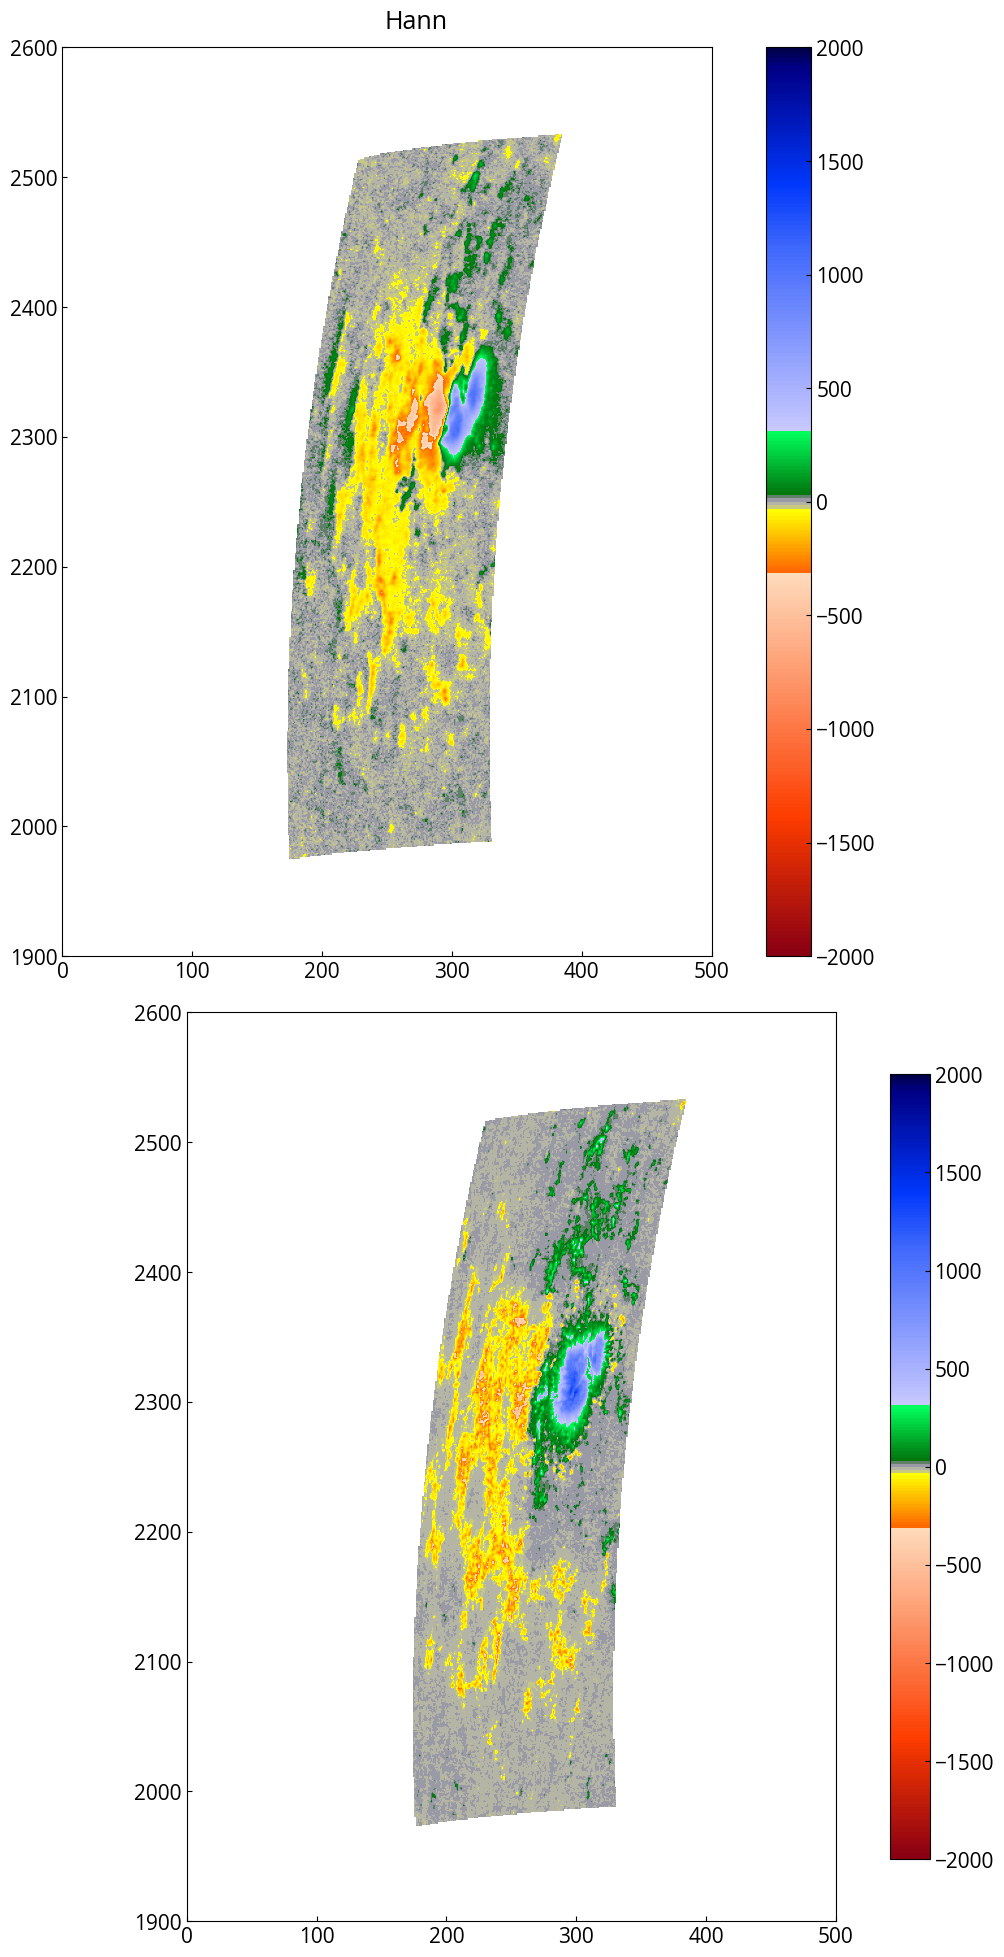

In [14]:
plt.figure(figsize=(12,20))
plt.subplot(211)
hmi.data[np.isnan(hrt_gauss.data)]=np.nan

hpc_coords = sunpy.map.all_coordinates_from_map(hmi)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
    
im=plt.imshow(hmi.data*~mask,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
plt.colorbar(im)
plt.xlim(0,500)
plt.ylim(1900,2600)

plt.subplot(212)
im2=plt.imshow(hrt_hann.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.suptitle('Hann')
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.tight_layout()
plt.show()

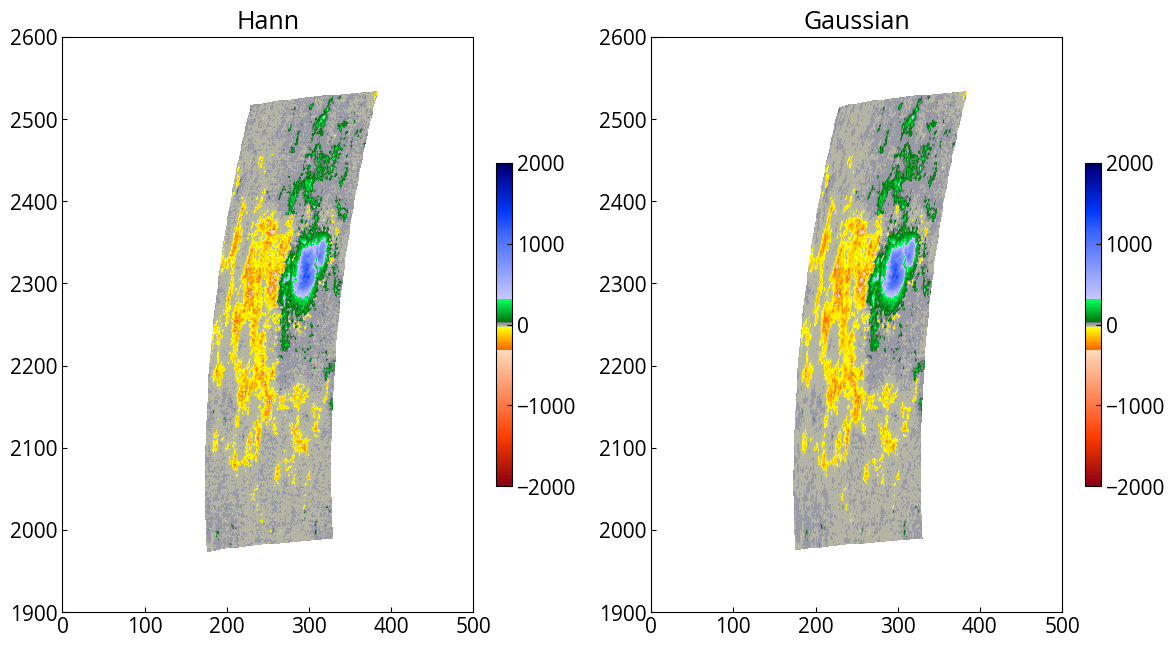

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(121)
im2=plt.imshow(hrt_hann.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann')
plt.xlim(0,500)
plt.ylim(1900,2600)

plt.subplot(122)
im2=plt.imshow(hrt_gauss.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Gaussian')
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.tight_layout()
plt.show()

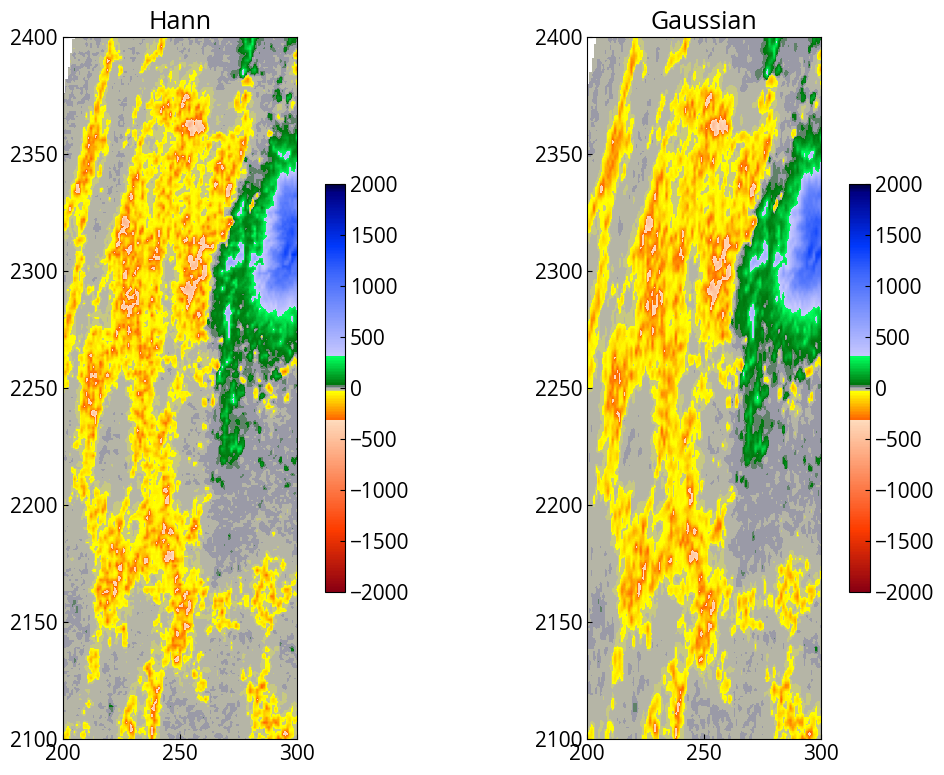

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(121)
im2=plt.imshow(hrt_hann.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann')
plt.xlim(200,300)
plt.ylim(2100,2400)

plt.subplot(122)
im2=plt.imshow(hrt_gauss.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Gaussian')
plt.xlim(200,300)
plt.ylim(2100,2400)
plt.tight_layout()
plt.show()

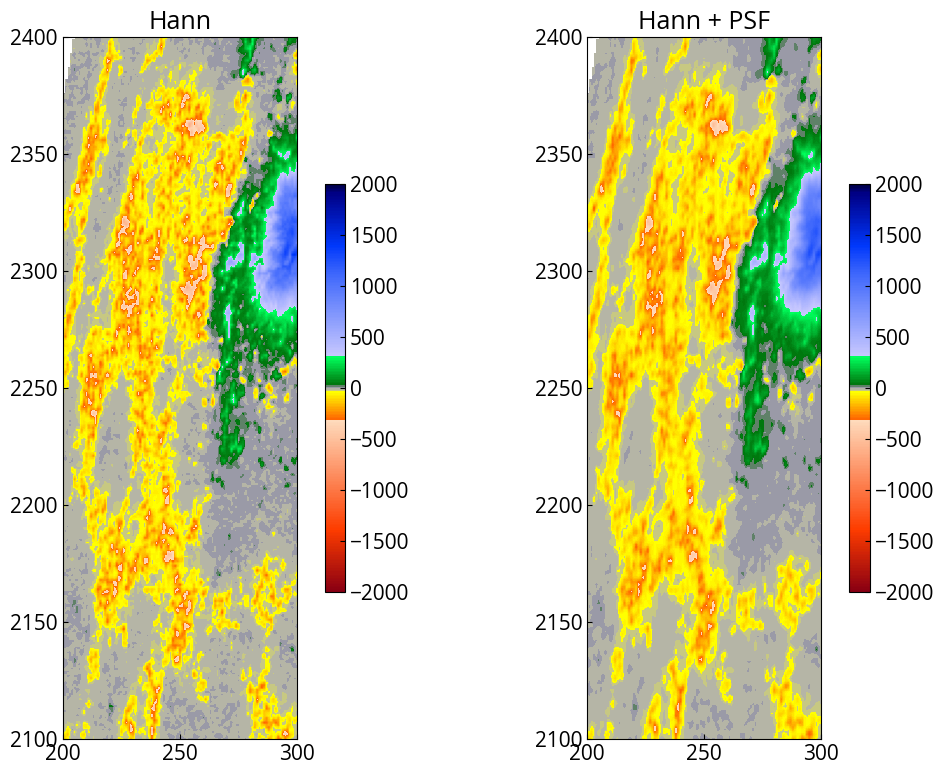

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(121)
im2=plt.imshow(hrt_hann.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann')
plt.xlim(200,300)
plt.ylim(2100,2400)

plt.subplot(122)
im2=plt.imshow(hrt_hann_psf.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann + PSF')
plt.xlim(200,300)
plt.ylim(2100,2400)
plt.tight_layout()
plt.show()

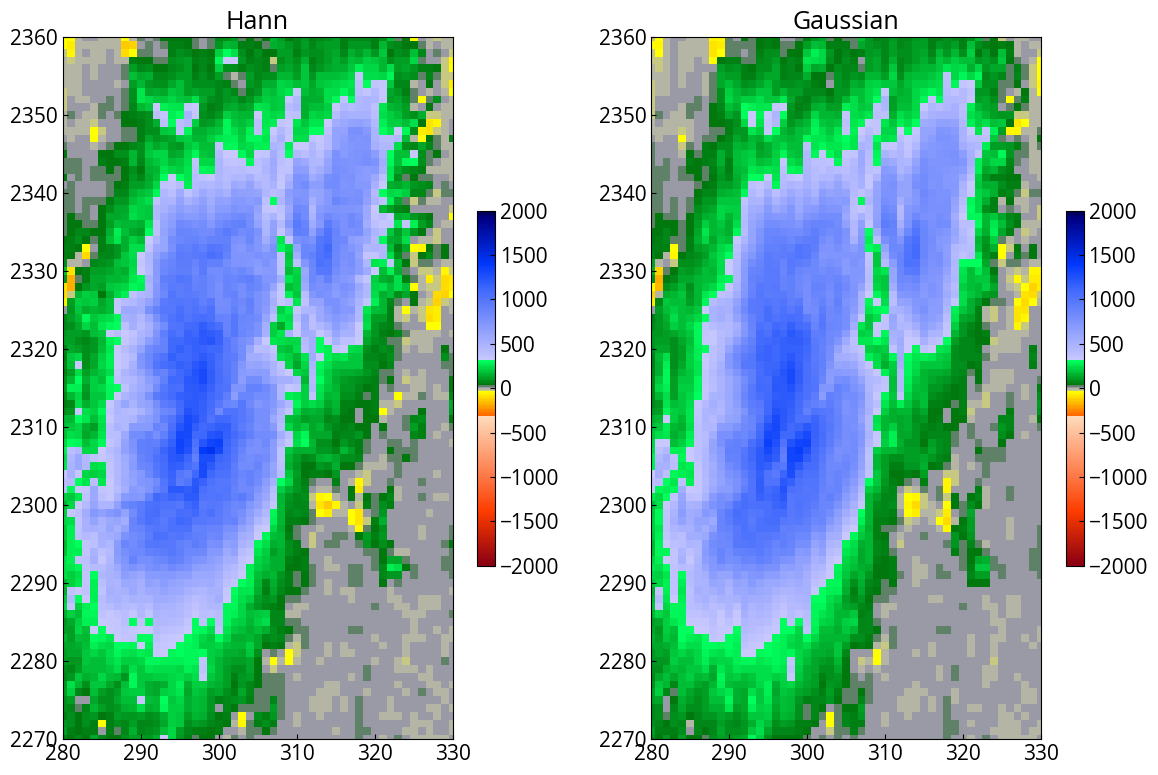

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(121)
im2=plt.imshow(hrt_hann.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann')
plt.xlim(280,330)
plt.ylim(2270,2360)

plt.subplot(122)
im2=plt.imshow(hrt_gauss.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Gaussian')
plt.xlim(280,330)
plt.ylim(2270,2360)
plt.tight_layout()
plt.show()

In [18]:
np.mean(hrt_hann.data[2270:2360,280:330])

311.48105198428095

In [19]:
np.mean(hrt_gauss.data[2270:2360,280:330])

311.508105513085

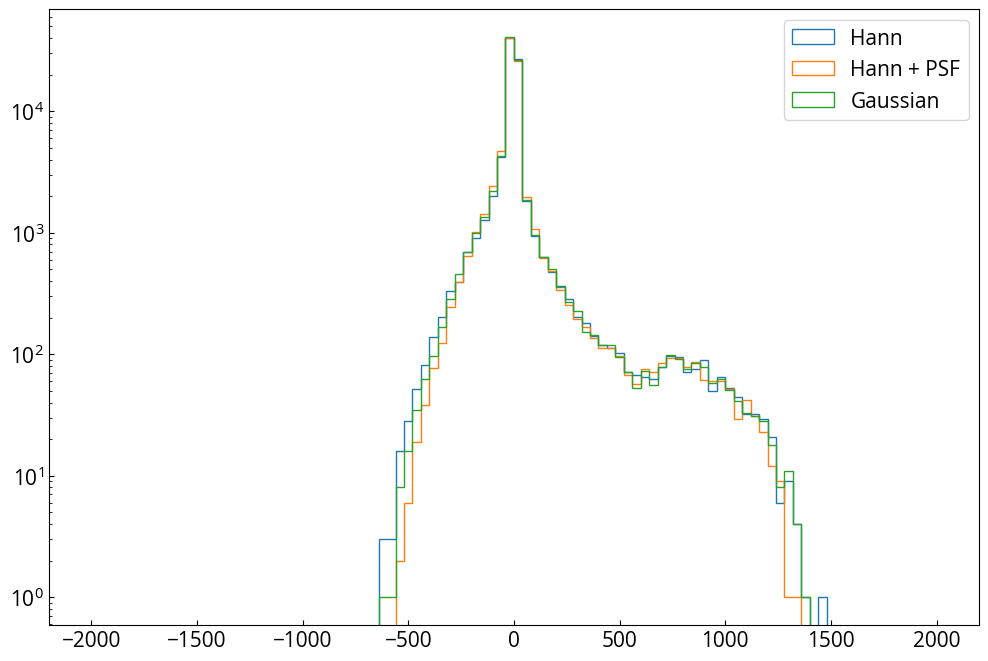

In [20]:
plt.figure(figsize=(12,8))
plt.hist(hrt_hann.data.flatten(),histtype='step',bins=100,label='Hann',range=(-2000,2000))
plt.hist(hrt_hann_psf.data.flatten(),histtype='step',bins=100,label='Hann + PSF',range=(-2000,2000))
plt.hist(hrt_gauss.data.flatten(),histtype='step',bins=100,label='Gaussian',range=(-2000,2000))
plt.yscale('log')
plt.legend()
plt.show()

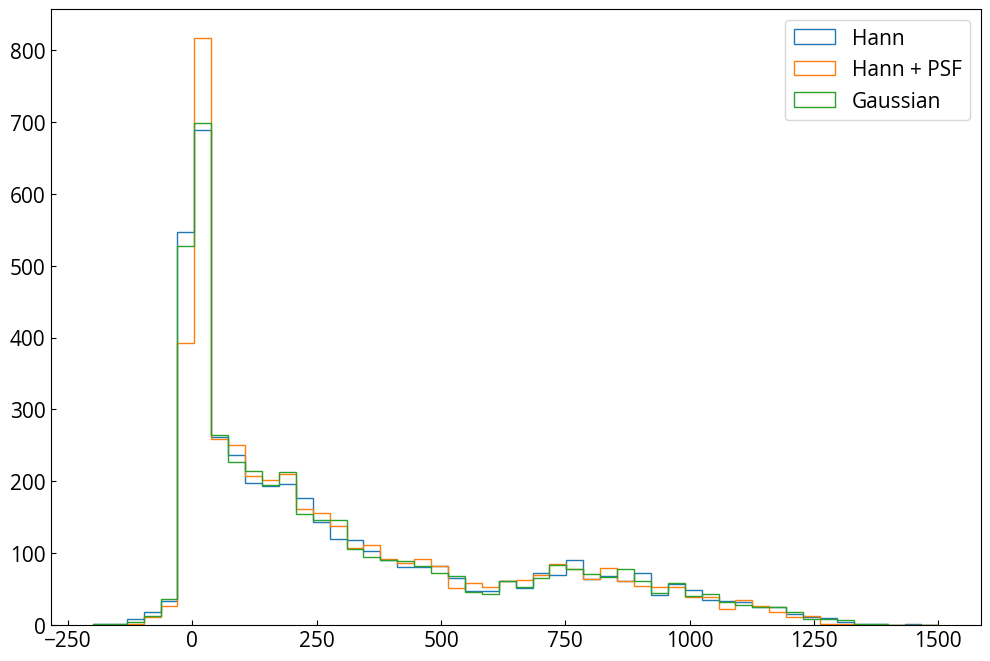

In [21]:
plt.figure(figsize=(12,8))
plt.hist(hrt_hann.data[2270:2360,280:330].flatten(),histtype='step',bins=50,label='Hann',range=(-200,1500))
plt.hist(hrt_hann_psf.data[2270:2360,280:330].flatten(),histtype='step',bins=50,label='Hann + PSF',range=(-200,1500))
plt.hist(hrt_gauss.data[2270:2360,280:330].flatten(),histtype='step',bins=50,label='Gaussian',range=(-200,1500))
plt.legend()
plt.show()

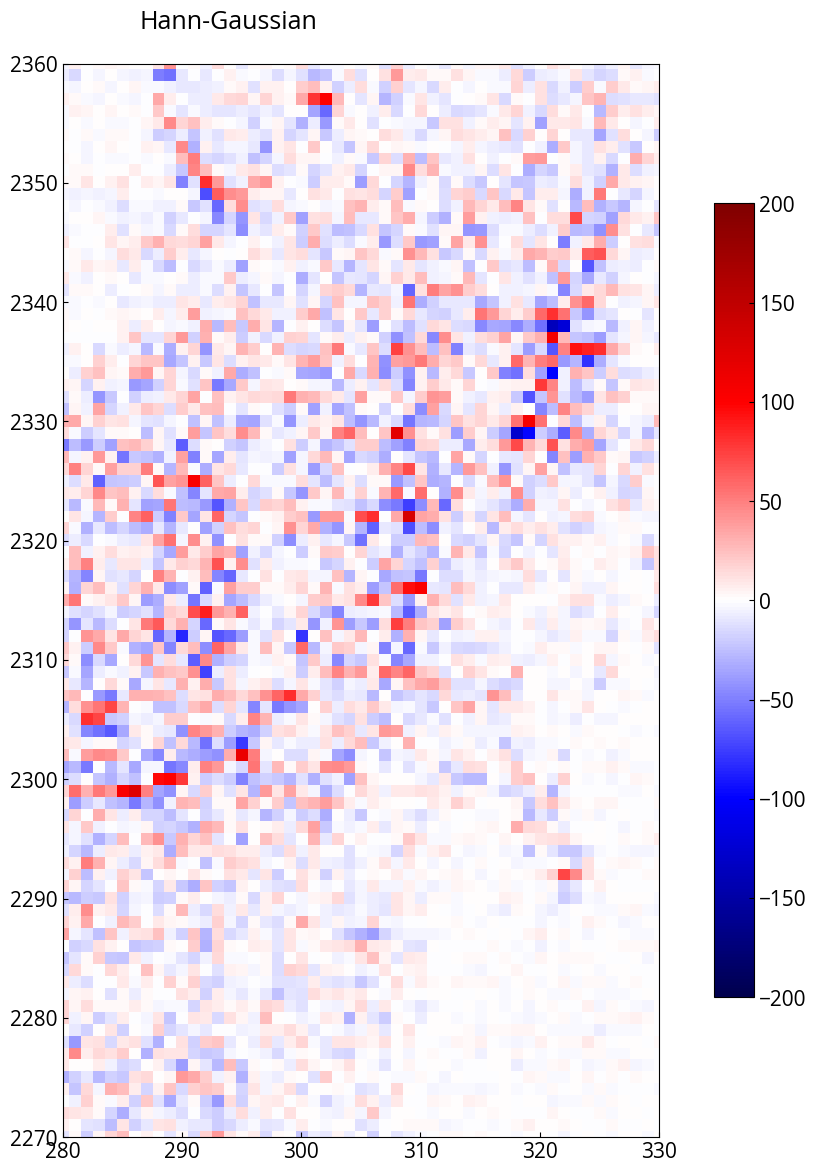

In [22]:
plt.figure(figsize=(12,12))
im2=plt.imshow(hrt_hann.data-hrt_gauss.data,origin="lower",cmap='seismic',vmin=-200,vmax=200)
plt.colorbar(im2,fraction=0.036)
plt.suptitle('Hann-Gaussian')
plt.xlim(280,330)
plt.ylim(2270,2360)
plt.tight_layout()
plt.show()

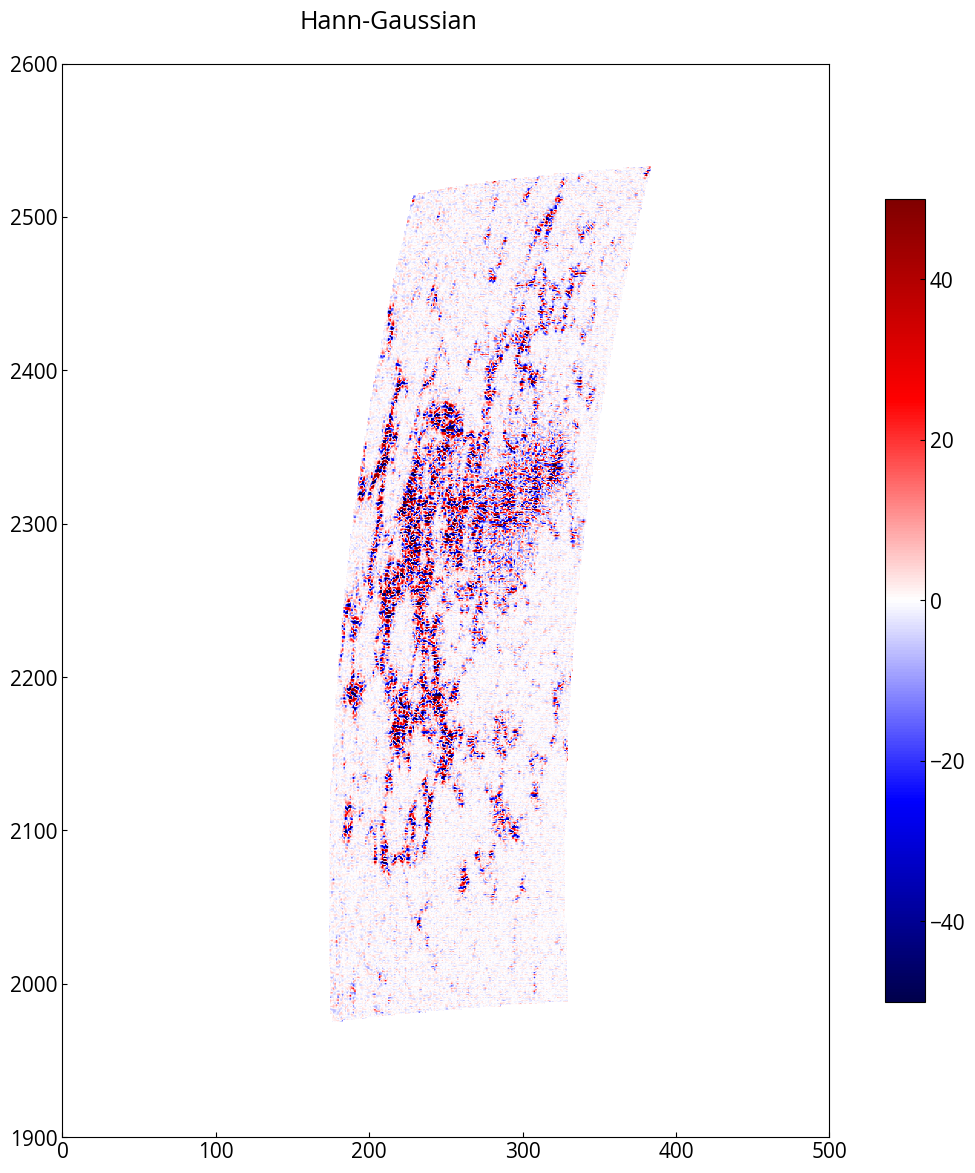

In [23]:
plt.figure(figsize=(12,12))
im2=plt.imshow(hrt_hann.data-hrt_gauss.data,origin="lower",cmap='seismic',vmin=-50,vmax=50)
plt.colorbar(im2,fraction=0.036)
plt.suptitle('Hann-Gaussian')
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.tight_layout()
plt.show()

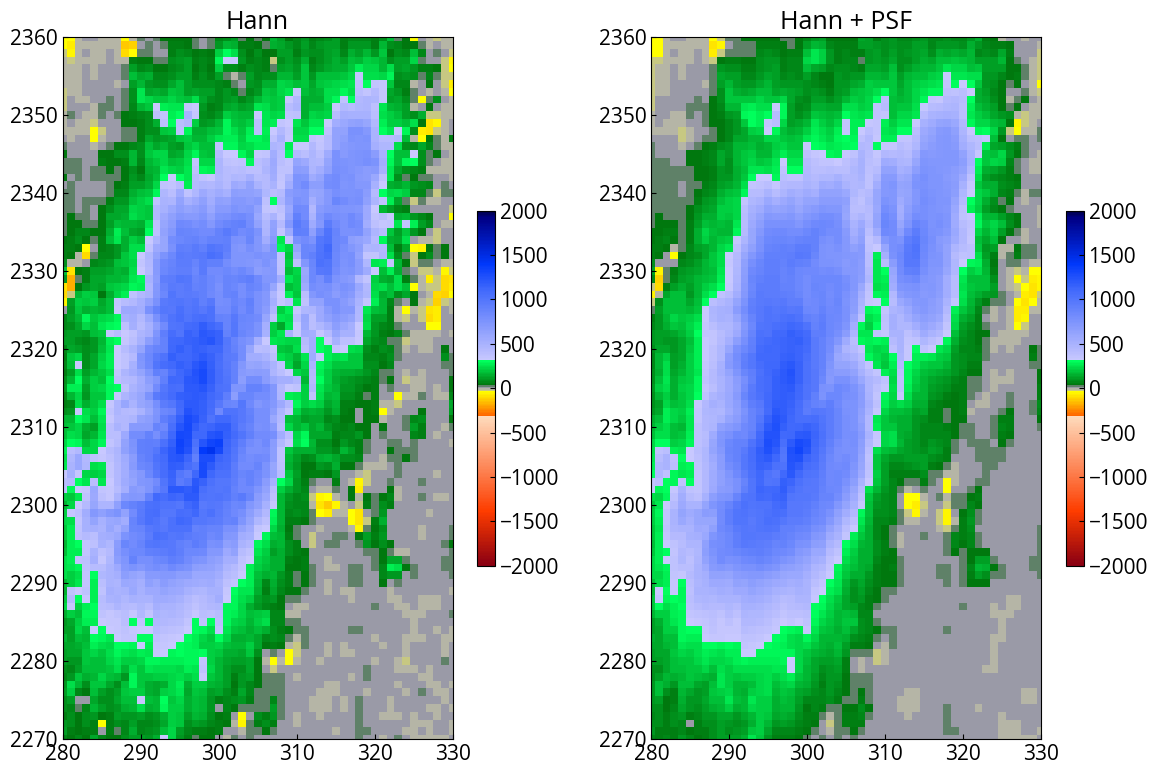

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(121)
im2=plt.imshow(hrt_hann.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann')
plt.xlim(280,330)
plt.ylim(2270,2360)

plt.subplot(122)
im2=plt.imshow(hrt_hann_psf.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.colorbar(im2,fraction=0.036)
plt.title('Hann + PSF')
plt.xlim(280,330)
plt.ylim(2270,2360)
plt.tight_layout()
plt.show()